In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("dark")
from tqdm import tqdm_notebook
import pandas as pd
from collections import defaultdict

# поменяйте на свой путь
DS_FILE_NAME = '../../data/data.hw4/stackoverflow_sample_125k.tsv'
TAGS_FILE_NAME = '../../data/data.hw4/top10_tags.tsv'

## Tag-Tag affinity

['android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript', 'jquery', 'php', 'python']


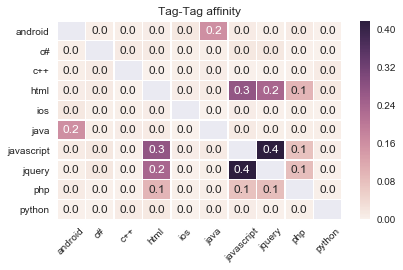

In [2]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = sorted(top_tags)
print(top_tags)
n_tags = len(top_tags)

tag2num = dict(zip(top_tags, range(n_tags)))
num2tag = dict(zip(range(n_tags), sorted(top_tags)))

df = pd.read_csv(DS_FILE_NAME, sep = '\t', header = None)

sum_tags = np.zeros((n_tags, n_tags))
for e in df[1]:
    tags = sorted(e.split(' '))
    for i1 in range(len(tags)):
        for i2 in range(i1, len(tags)):
            sum_tags[tag2num[tags[i1]], tag2num[tags[i2]]] += 1
sum_tags = (sum_tags + sum_tags.T - np.diag(np.diag(sum_tags)))
d_tags = np.zeros((n_tags, n_tags))
for i in range(n_tags):
    for j in range(n_tags):
        if i != j:
            d_tags[i, j] = (sum_tags[i, j] / sum_tags[i, i]) * (sum_tags[i, j] / sum_tags[j, j])
        else:
            d_tags[i, j] = np.nan

plt.figure(figsize=(6, 4))
ax = sns.heatmap(pd.DataFrame(d_tags**0.5, index=top_tags, columns=top_tags), annot=True, fmt=".1f", linewidths=.5)
plt.title('Tag-Tag affinity')
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.savefig('tag_tag_affinity.png')
plt.show()        

## Words-Tag affinity

### Extract most frequent words

In [3]:
from collections import Counter
cw = Counter()
for e in df[0]:
    cw.update(e.split(' '))

n_words = 1000
freq_words = sorted([e[0] for e in sorted(cw.items(), key=lambda x: -x[1])[:n_words]])

word2num = dict(zip(freq_words, range(n_words)))
num2word = dict(zip(range(n_words), freq_words))
freq_words_set = set(freq_words)

### Word-Word affinity

In [4]:
sum_words = np.zeros((n_words, n_words))
for e in tqdm_notebook(df[0], total=len(df)):
    words = list(set(e.split(' ')) & freq_words_set)
    for i1 in range(len(words)):
        for i2 in range(i1, len(words)):
            sum_words[word2num[words[i1]], word2num[words[i2]]] += 1
sum_words = (sum_words + sum_words.T - np.diag(np.diag(sum_words)))

### Words clustering

In [5]:
d_words = np.zeros((n_words, n_words))
for i in range(n_words):
    for j in range(n_words):
        d_words[i, j] = (sum_words[i, j] / sum_words[i, i]) * (sum_words[i, j] / sum_words[j, j])
        
from sklearn.cluster import SpectralClustering
n_clusters = 100
cl = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=7)
y = cl.fit_predict(d_words)

order = []
dens = []
word_clusters = []
for j in range(n_clusters):
    dens.append(np.mean(d_words[np.where(y == j)][:,np.where(y == j)]))
for j in np.argsort(-np.array(dens)):
    print([j, dens[j]], end = ': ')
    cluster = set()
    for i in range(len(y)):
        if y[i] == j:
            print(num2word[i], end=' ')
            order.append(i)
            cluster.add(num2word[i])
    word_clusters.append(cluster)
    print()
    print()

[39, 1.0]: 0 

[95, 1.0]: help 

[66, 1.0]: document 

[5, 1.0]: t 

[73, 1.0]: file 

[91, 0.92085115604503365]:  i the to 

[96, 0.89304697986577186]: artifactid groupid 

[40, 0.88826705518298721]: gt lt 

[59, 0.84768479785162909]: li ul 

[24, 0.83185307233267469]: td tr 

[6, 0.81736752248284561]: layoutinflater viewgroup 

[20, 0.78178290561499697]: height width 

[11, 0.76906873624910843]: bundle oncreate savedinstancestate 

[12, 0.66442856144846896]: +id layout_height layout_width linearlayout match_parent wrap_content 

[21, 0.63546851034492435]: x y 

[69, 0.62904105668697419]: function var 

[13, 0.61730135768238492]: console log 

[46, 0.61024045707210162]: cout endl std 

[27, 0.6071067138375752]: advance thanks 

[71, 0.60222243113374763]: bin usr 

[19, 0.60112651878000889]: 1px border solid 

[49, 0.58613957981307585]: button click 

[30, 0.55638321633251053]: our we 

[54, 0.54948324096137036]: private public void 

[82, 0.547775611829458]: bar foo 

[10, 0.546182489

### Calculate Cluster(Words)-Tag affinity

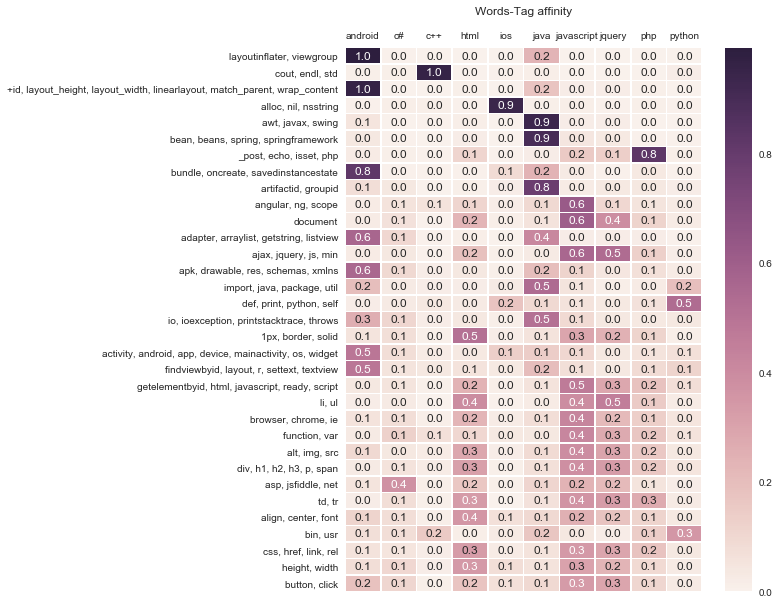

In [6]:
sum_tag_cluster = np.zeros((n_tags, n_clusters))
sum_tags = np.zeros((n_tags, 1))
sum_clusters = np.zeros((n_clusters, 1))
for text, tag in tqdm_notebook(zip(df[0], df[1]), total=len(df)):
    tags = tag.split(' ')
    words = set(text.split(' ')) & freq_words_set
    clusters = [i for i in range(n_clusters) if len(word_clusters[i] & words) > 0]
    for i in clusters:
        sum_clusters[i] += 1
    for tag in tags:
        sum_tags[tag2num[tag]] += 1
        for i in clusters:
            sum_tag_cluster[tag2num[tag], i] += 1
            
d_tag_cluster = np.zeros((n_tags, n_clusters))
for i in range(n_tags):
    for j in range(n_clusters):
        d_tag_cluster[i, j] = (sum_tag_cluster[i, j] / sum_clusters[j])
        
ind = d_tag_cluster.max(axis=0) >= 0.33
columns = [', '.join(sorted(list(word_clusters[i]))) for i in range(n_clusters) if i in np.where(ind)[0]]


d_tag_cluster_ind = d_tag_cluster[:, ind]
order = np.argsort(d_tag_cluster_ind.max(axis=0))[::-1]
columns_order = [columns[order[i]] for i in range(len(order))]

fig = plt.figure(figsize=(8, 10))
ax = sns.heatmap(pd.DataFrame(d_tag_cluster_ind[:, order], index=top_tags, columns=columns_order).transpose(), 
                 annot=True, fmt=".1f", linewidths=.5)
plt.title('Words-Tag affinity', y=1.05)
ax.xaxis.tick_top()

plt.savefig('words_tag_affinity.png', bbox_inches='tight')   
plt.show()

In [56]:
cw['std'], cw['cout'], cw['endl'], sum_words[word2num['cout'], word2num['endl']], \
sum_words[word2num['cout'], word2num['std']], \
sum_words[word2num['endl'], word2num['std']]

(13365, 6868, 4528, 1194.0, 1310.0, 960.0)

In [60]:
cw['layoutinflater'], cw['viewgroup'], sum_words[word2num['layoutinflater'], word2num['viewgroup']]

(3166, 3241, 764.0)

In [63]:
tags_list = ['javascript', 'jquery', 'html', 'php', 'java', 'android', 'c#', 'c++', 'ios', 'python']
tags_order = [tag2num[e] for e in tags_list]

In [9]:
sum_tag_word = np.zeros((n_tags, n_words))
sum_tags = np.zeros((n_tags, 1))
sum_words = np.zeros((n_words, 1))
for text, tag in tqdm_notebook(zip(df[0], df[1]), total=len(df)):
    tags = tag.split(' ')
    words = set(text.split(' ')) & freq_words_set
    for word in words:
        sum_words[word2num[word]] += 1
    for tag in tags:
        sum_tags[tag2num[tag]] += 1
        for word in words:
            sum_tag_word[tag2num[tag], word2num[word]] += 1

In [18]:
d_word_word = np.zeros((n_words, n_words))
for i in tqdm_notebook(range(n_words)):
    for j in range(n_words):
        for k in range(n_tags):
            #d_word_word[i, j] += sum_tag_word[k, i] / sum_words[i] * sum_tag_word[k, j] / sum_words[j]
            d_word_word[i, j] += sum_tag_word[k, i] / sum_tags[k] * sum_tag_word[k, j] / sum_tags[k]

In [22]:
n_clusters = 100
cl = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=7)
y = cl.fit_predict(d_word_word)

order = []
dens = []
word_clusters = []
for j in range(n_clusters):
    dens.append(np.mean(d_word_word[np.where(y == j)][:,np.where(y == j)]))
for j in np.argsort(-np.array(dens)):
    print([j, dens[j]], end = ': ')
    cluster = set()
    for i in range(len(y)):
        if y[i] == j:
            print(num2word[i], end=' ')
            order.append(i)
            cluster.add(num2word[i])
    word_clusters.append(cluster)
    print()
    print()

[4, 6.6449000611017199]:  a and i in is it the this to 

[34, 2.0497308836885924]: gt lt 

[13, 1.435653667929266]: 0 1 am an any as be but can code do for from get have how if like m my not of on or s so t that there using want what when with 

[27, 0.46536300072332037]: php 

[86, 0.32768869899031028]: new private public string system void 

[89, 0.28084730220934484]: div href html http id input page src text type 

[8, 0.2623987776548371]: console document function javascript js var 

[12, 0.20263185539280912]: 10 2 3 4 5 6 7 8 about after all also are at by call could create d does doesn don else error example file find first following has help here however into just know line make me more need no now one only other output problem question return run same see should some something thanks then time tried trying two up use value ve was way which while why will work working works would x you 

[21, 0.092520954563771574]: def import print py python 

[1, 0.076773440114505681]: _post ar

In [23]:
sum_tag_cluster = np.zeros((n_tags, n_clusters))
sum_tags = np.zeros((n_tags, 1))
sum_clusters = np.zeros((n_clusters, 1))
for text, tag in tqdm_notebook(zip(df[0], df[1]), total=len(df)):
    tags = tag.split(' ')
    words = set(text.split(' ')) & freq_words_set
    clusters = [i for i in range(n_clusters) if len(word_clusters[i] & words) > 0]
    for i in clusters:
        sum_clusters[i] += 1
    for tag in tags:
        sum_tags[tag2num[tag]] += 1
        for i in clusters:
            sum_tag_cluster[tag2num[tag], i] += 1
            
d_tag_cluster = np.zeros((n_tags, n_clusters))
for i in range(n_tags):
    for j in range(n_clusters):
        d_tag_cluster[i, j] = (sum_tag_cluster[i, j] / sum_clusters[j])

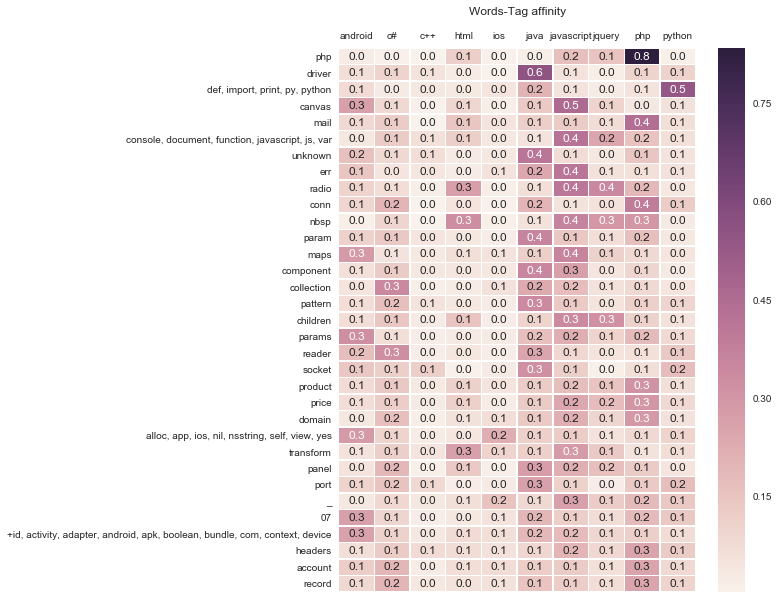

In [27]:
ind = d_tag_cluster.max(axis=0) >= 0.25
columns = [', '.join(sorted(list(word_clusters[i]))[:10]) for i in range(n_clusters) if i in np.where(ind)[0]]


d_tag_cluster_ind = d_tag_cluster[:, ind]
order = np.argsort(d_tag_cluster_ind.max(axis=0))[::-1]
columns_order = [columns[order[i]] for i in range(len(order))]

fig = plt.figure(figsize=(8, 10))
ax = sns.heatmap(pd.DataFrame(d_tag_cluster_ind[:, order], index=top_tags, columns=columns_order).transpose(), 
                 annot=True, fmt=".1f", linewidths=.5)
plt.title('Words-Tag affinity', y=1.05)
ax.xaxis.tick_top()

plt.savefig('words_tag_affinity_1.png', bbox_inches='tight')   
plt.show()